## Experiment to Visualize LFP Decision Boundaries on Toy Data

### Imports

In [1]:
import copy
import os
import random

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from experiment_utils.data import dataloaders, datasets, transforms
from experiment_utils.evaluation import evaluate
from experiment_utils.model import models
from experiment_utils.model.model_definitions import ToyDataDense
from experiment_utils.utils.utils import register_backward_normhooks
from lfprop.propagation import propagator_lxt as propagator
from lfprop.rewards import rewards

### Experiment Variables

In [2]:
dataset_name = "blobs"  # Options: swirls, circles, blobs
n_channels = 2
model_name = "toydata-dense"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lrs = np.sort(
    np.array(
        [np.arange(1, 11, 1, dtype=float) * 10**x for x in [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]]
    ).flatten()
)
momentum = 0.95
reward_name = "softmaxlossreward"
loss_name = "ce-loss"
norm_backward = False
epochs = 10  # 15 epochs for swirls, 10 otherwise
n_datasets = 5

savepath = "<path to save results in>"
data_path = "<path where dataset is saved>"

retrain_models = False
redraw_data = False

### Trainer Class

In [3]:
class Trainer:
    def __init__(
        self,
        model,
        train_dataset,
        test_dataset,
        val_dataset,
        optimizer,
        criterion,
        device,
        lfp_composite=None,
        norm_backward=False,
    ):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.val_dataset = val_dataset
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = None
        self.device = device
        self.lfp_composite = lfp_composite
        self.norm_backward = norm_backward
        self.global_epoch = 0
        self.global_step = 0

        self.train_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
        )
        self.test_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
        )
        self.val_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
        )

        self.accuracy_log = {"train": [], "test": []}

    def grad_step(self, inputs, labels):
        # Backward norm
        if self.norm_backward:
            norm_handles = register_backward_normhooks(self.model)
        else:
            norm_handles = []

        self.model.train()
        with torch.enable_grad():
            self.optimizer.zero_grad()
            out = self.model(inputs)

            reward = self.criterion(out, labels)
            reward.backward()

            self.optimizer.step()

        self.model.eval()

        for handle in norm_handles:
            handle.remove()

        self.global_step += 1

    def lfp_step(self, inputs, labels):
        self.model.train()

        with torch.enable_grad():
            self.optimizer.zero_grad()
            with self.lfp_composite.context(self.model) as modified:
                inputs = inputs.detach().requires_grad_(True)
                outputs = modified(inputs)

                # Calculate reward
                # Do like this to avoid tensors being kept in memory
                reward = torch.from_numpy(self.criterion(outputs, labels).detach().cpu().numpy()).to(device)

                # Write LFP Values into .grad attributes
                torch.autograd.grad((outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False)[0]

                for name, param in self.model.named_parameters():
                    param.grad = -param.feedback

                self.optimizer.step()

        self.model.eval()

        self.global_step += 1

    def train(
        self,
        epochs,
        verbose=False,
        savepath=None,
        savename="ckpt",
        saveappendage="last",
        fromscratch=False,
    ):
        if not fromscratch and savepath:
            self.load(savepath, savename, saveappendage)

        if verbose:
            eval_stats = self.eval(datamodes=["train", "test"])

            print(eval_stats)

            print(
                "Initial Eval: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                    float(np.mean(eval_stats["train"]["criterion"])),
                    (
                        float(eval_stats["train"]["accuracy_p050"])
                        if "accuracy_p050" in eval_stats["train"].keys()
                        else float(eval_stats["train"]["micro_accuracy_top1"])
                    ),
                    float(np.mean(eval_stats["test"]["criterion"])),
                    (
                        float(eval_stats["test"]["accuracy_p050"])
                        if "accuracy_p050" in eval_stats["test"].keys()
                        else float(eval_stats["test"]["micro_accuracy_top1"])
                    ),
                )
            )

        for epoch in range(epochs):
            with tqdm(total=len(self.train_loader), disable=not verbose) as pbar:
                for index, (inputs, labels) in enumerate(self.train_loader):
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    if self.lfp_composite is None:
                        # Grad Step
                        self.grad_step(inputs, labels)
                    else:
                        # LFP Step
                        self.lfp_step(inputs, labels)

                    pbar.update(1)

                    if self.global_step % 5 == 0:
                        eval_stats = self.eval(datamodes=["train", "test"])
                        self.accuracy_log["train"].append(
                            (
                                float(eval_stats["train"]["accuracy_p050"])
                                if "accuracy_p050" in eval_stats["train"].keys()
                                else float(eval_stats["train"]["micro_accuracy_top1"])
                            ),
                        )
                        self.accuracy_log["test"].append(
                            (
                                float(eval_stats["test"]["accuracy_p050"])
                                if "accuracy_p050" in eval_stats["test"].keys()
                                else float(eval_stats["test"]["micro_accuracy_top1"])
                            ),
                        )

            if verbose:
                eval_stats = self.eval(datamodes=["train", "test"])

                print(
                    "Epoch {}/{}: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                        epoch + 1,
                        epochs,
                        float(np.mean(eval_stats["train"]["criterion"])),
                        (
                            float(eval_stats["train"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["train"].keys()
                            else float(eval_stats["train"]["micro_accuracy_top1"])
                        ),
                        float(np.mean(eval_stats["test"]["criterion"])),
                        (
                            float(eval_stats["test"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["test"].keys()
                            else float(eval_stats["test"]["micro_accuracy_top1"])
                        ),
                    )
                )

            self.global_epoch += 1

            if savepath:
                self.save(savepath, savename, "last")

    def eval(self, datamodes=["train", "test", "val"]):
        return_dict = {}

        if "train" in datamodes:
            return_data = evaluate.eval(self.model, self.train_loader, self.criterion, device)
            return_dict["train"] = return_data
        if "test" in datamodes:
            return_data = evaluate.eval(self.model, self.test_loader, self.criterion, device)
            return_dict["test"] = return_data
        if "val" in datamodes:
            return_data = evaluate.eval(self.model, self.val_loader, self.criterion, device)
            return_dict["val"] = return_data

        return return_dict

    def save(self, savepath, savename, saveappendage):
        checkpoint = {
            "epoch": self.global_epoch,
            "step": self.global_step,
            "random_state": {
                "torch": torch.get_rng_state(),
                "cuda": torch.cuda.get_rng_state(self.device),
                "numpy": np.random.get_state(),
                "random": random.getstate(),
            },
        }
        if self.model:
            checkpoint["model"] = self.model.state_dict()
        if self.optimizer:
            checkpoint["optimizer"] = self.optimizer.state_dict()
        if self.scheduler:
            checkpoint["scheduler"] = self.scheduler.state_dict()
        if self.accuracy_log:
            checkpoint["accuracy_log"] = self.accuracy_log

        torch.save(checkpoint, os.path.join(savepath, f"{savename}-{saveappendage}.pt"))

    def load(self, savepath, savename, saveappendage):
        if os.path.exists(os.path.join(savepath, f"{savename}-{saveappendage}.pt")):
            checkpoint = torch.load(os.path.join(savepath, f"{savename}-{saveappendage}.pt"))
            if self.model:
                self.model.load_state_dict(checkpoint["model"])
            if self.optimizer:
                self.optimizer.load_state_dict(checkpoint["optimizer"])
            if self.scheduler:
                self.scheduler.load_state_dict(checkpoint["scheduler"])
            if "accuracy_log" in checkpoint:
                self.accuracy_log = checkpoint["accuracy_log"]
            self.global_epoch = checkpoint["epoch"]
            self.global_step = checkpoint["step"]

            torch.set_rng_state(checkpoint["random_state"]["torch"])
            torch.cuda.set_rng_state(checkpoint["random_state"]["cuda"], device)
            np.random.set_state(checkpoint["random_state"]["numpy"])
            random.setstate(checkpoint["random_state"]["random"])

        else:
            print("No checkpoint found... not loading anything.")

### Paths, Dataset, Model

In [4]:
os.makedirs(data_path, exist_ok=True)
train_datasets = []
for d in range(n_datasets):
    train_datasets.append(
        datasets.get_dataset(
            dataset_name,
            os.path.join(data_path, f"{dataset_name}-train-{d}.json"),
            transforms.get_transforms(dataset_name, "train"),
            mode="train",
            redraw=redraw_data,
        )
    )
test_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-test.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    redraw=redraw_data,
)
val_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-val.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    redraw=redraw_data,
)

propagation_composites = {
    "lfp-epsilon": propagator.LFPEpsilonComposite(
        norm_backward=norm_backward,
    ),
    "vanilla-gradient": None,
}

if retrain_models or not os.path.exists(os.path.join(savepath, "init-ckpts", "initmodel-0.pt")):
    init_models = [models.get_model(model_name, n_channels, d.num_classes, device) for d in train_datasets]
    os.makedirs(os.path.join(savepath, "init-ckpts"), exist_ok=True)
    for m, model in enumerate(init_models):
        torch.save(
            model.state_dict(),
            os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"),
        )
else:
    init_models = [models.get_model(model_name, n_channels, d.num_classes, device) for d in train_datasets]
    for m, model in enumerate(init_models):
        statedict = torch.load(os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"))
        model.load_state_dict(statedict)

trainers = {}
for lr in lrs:
    trainers[lr] = {}
    for name, prop_comp in propagation_composites.items():
        trainers[lr][name] = []
        for d in train_datasets:
            model = copy.deepcopy(init_models[m])
            trainers[lr][name].append(
                Trainer(
                    model=model,
                    train_dataset=d,
                    test_dataset=test_dataset,
                    val_dataset=val_dataset,
                    optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum),
                    criterion=(
                        rewards.get_reward(reward_name, device)
                        if prop_comp is not None
                        else rewards.get_reward(loss_name, device)
                    ),
                    device=device,
                    lfp_composite=prop_comp,
                    norm_backward=norm_backward,
                )
            )

Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs/blobs-datasets/blobs-train-0.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs/blobs-datasets/blobs-train-1.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs/blobs-datasets/blobs-train-2.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs/blobs-datasets/blobs-train-3.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs/blobs-datasets/blobs-train-4.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-back

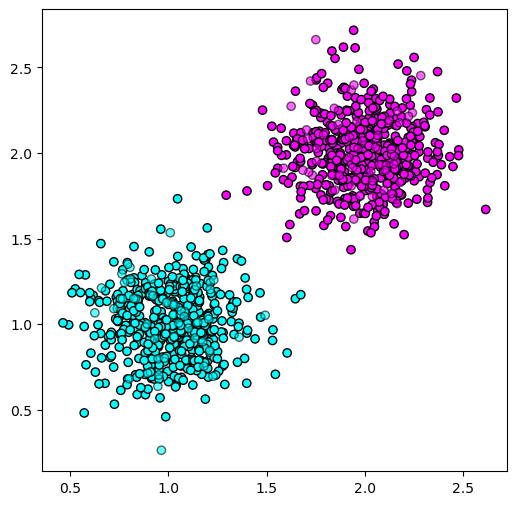

In [5]:
# Plot Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

X = np.array([s[0] for s in train_datasets[0].samples])
y = [s[1] for s in train_datasets[0].samples]
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k")


X = np.array([s[0] for s in test_dataset.samples])
y = [s[1] for s in test_dataset.samples]
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k", alpha=0.6)

plt.show()

In [6]:
accuracies = {"val": {}, "test": {}, "train": {}}
for lr, trainers_lr in trainers.items():
    print(f"LR {lr}...")
    accuracies["val"][lr] = {}
    accuracies["test"][lr] = {}
    accuracies["train"][lr] = {}
    for name, trainer_list in trainers_lr.items():
        accuracies["val"][lr][name] = []
        accuracies["test"][lr][name] = []
        accuracies["train"][lr][name] = []

        for t, trainer in enumerate(trainer_list):
            ckpt_path = os.path.join(savepath, f"ckpts-lr-{lr}")
            os.makedirs(ckpt_path, exist_ok=True)
            savename = f"{name}-model-{t}"
            saveappendage = "last"
            if retrain_models or not os.path.exists(os.path.join(ckpt_path, f"{savename}-{saveappendage}.pt")):
                # print(f"Training {t+1}-th trainer for propagator {name}...")
                trainer.train(
                    epochs=epochs,
                    verbose=False,
                    savepath=ckpt_path,
                    savename=savename,
                    saveappendage=saveappendage,
                    fromscratch=True,
                )
            else:
                # print(f"Loading checkpoint {os.path.join(ckpt_path, f'{savename}-{saveappendage}.pt')}")
                trainer.load(savepath=ckpt_path, savename=savename, saveappendage=saveappendage)
            eval_stats = trainer.eval(datamodes=["test", "val", "train"])
            # print(f'(Test Accuracy) {res["test"]["accuracy"]}')
            accuracies["val"][lr][name].append(
                eval_stats["val"]["accuracy_p050"]
                if "accuracy_p050" in eval_stats["val"].keys()
                else eval_stats["val"]["micro_accuracy_top1"]
            )
            accuracies["test"][lr][name].append(
                eval_stats["test"]["accuracy_p050"]
                if "accuracy_p050" in eval_stats["test"].keys()
                else eval_stats["test"]["micro_accuracy_top1"]
            )
            accuracies["train"][lr][name].append(
                eval_stats["train"]["accuracy_p050"]
                if "accuracy_p050" in eval_stats["train"].keys()
                else eval_stats["train"]["micro_accuracy_top1"]
            )

LR 1e-10...
LR 2e-10...
LR 3e-10...
LR 4e-10...
LR 5e-10...
LR 6e-10...
LR 7.000000000000001e-10...
LR 8e-10...
LR 9e-10...
LR 1e-09...
LR 2e-09...
LR 3.0000000000000004e-09...
LR 4e-09...
LR 5e-09...
LR 6.000000000000001e-09...
LR 7.000000000000001e-09...
LR 8e-09...
LR 9.000000000000001e-09...
LR 1e-08...
LR 2e-08...
LR 3.0000000000000004e-08...
LR 4e-08...
LR 5e-08...
LR 6.000000000000001e-08...
LR 7e-08...
LR 8e-08...
LR 9e-08...
LR 1e-07...
LR 2e-07...
LR 3e-07...
LR 4e-07...
LR 5e-07...
LR 6e-07...
LR 7e-07...
LR 8e-07...
LR 9e-07...
LR 1e-06...
LR 2e-06...
LR 3e-06...
LR 4e-06...
LR 4.9999999999999996e-06...
LR 6e-06...
LR 7e-06...
LR 8e-06...
LR 9e-06...
LR 9.999999999999999e-06...
LR 1e-05...
LR 2e-05...
LR 3.0000000000000004e-05...
LR 4e-05...
LR 5e-05...
LR 6.000000000000001e-05...
LR 7.000000000000001e-05...
LR 8e-05...
LR 9e-05...
LR 0.0001...
LR 0.0002...
LR 0.00030000000000000003...
LR 0.0004...
LR 0.0005...
LR 0.0006000000000000001...
LR 0.0007...
LR 0.0008...
LR 0.0009

/home/lweber/anaconda3/envs/lxtenv/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


LR 0.1...
LR 0.2...
LR 0.30000000000000004...
LR 0.4...
LR 0.5...
LR 0.6000000000000001...
LR 0.7000000000000001...
LR 0.8...
LR 0.9...
LR 1.0...
LR 2.0...
LR 3.0...
LR 4.0...
LR 5.0...
LR 6.0...
LR 7.0...
LR 8.0...
LR 9.0...
LR 10.0...
LR 20.0...
LR 30.0...
LR 40.0...
LR 50.0...
LR 60.0...
LR 70.0...
LR 80.0...
LR 90.0...
LR 100.0...
LR 200.0...
LR 300.0...
LR 400.0...
LR 500.0...
LR 600.0...
LR 700.0...
LR 800.0...
LR 900.0...
LR 1000.0...
LR 2000.0...
LR 3000.0...
LR 4000.0...
LR 5000.0...
LR 6000.0...
LR 7000.0...
LR 8000.0...
LR 9000.0...
LR 10000.0...


In [7]:
# Plot Settings
# Set font properties.
import matplotlib.font_manager as font_manager

font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams["axes.linewidth"] = 1.5

### Plot Val Accuracies Over LR

val
MAX: lfp-epsilon - 0.0004
MAX: vanilla-gradient - 0.007


/tmp/ipykernel_562380/2261479294.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


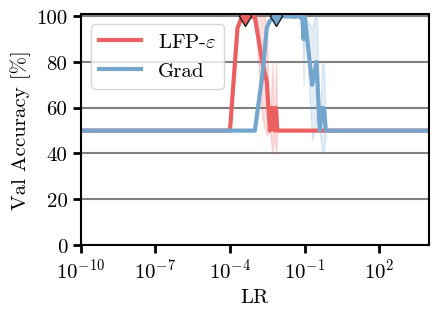

test
MAX: lfp-epsilon - 0.00030000000000000003
MAX: vanilla-gradient - 0.005


/tmp/ipykernel_562380/2261479294.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


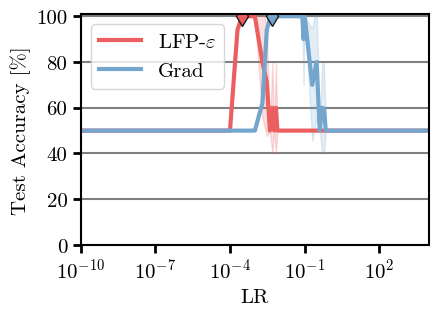

train
MAX: lfp-epsilon - 0.0004
MAX: vanilla-gradient - 0.03


/tmp/ipykernel_562380/2261479294.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


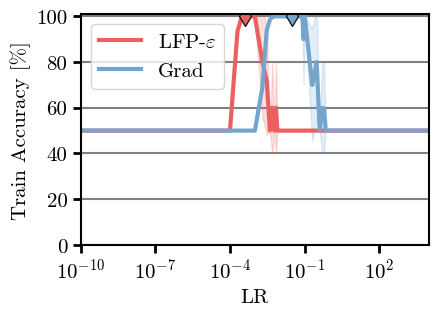

In [8]:
import matplotlib.cm as cm


def plot_accuracies(accuracy_res, name, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))

    lrs = np.sort([k for k in accuracy_res.keys()])
    methods = [m for m in accuracy_res[lrs[0]].keys()]

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    maxacclrs = []

    for m, method in enumerate(methods):
        plot_means = []
        plot_stds = []
        for lr in lrs:
            plot_means.append(np.mean(accuracy_res[lr][method]))
            plot_stds.append(np.std(accuracy_res[lr][method]))

        plot_means = np.array(plot_means)
        plot_stds = np.array(plot_stds)

        maxx = lrs[np.argmax(plot_means)]
        maxy = np.max(plot_means)
        print(f"MAX: {method} - {maxx}")
        maxacclrs.append((method, maxx, maxy))

        ax.plot(
            lrs,
            plot_means,
            color=palette[m],
            label=LABELS[method],
            linewidth=3,
            alpha=1,
        )
        ax.plot(
            maxx,
            maxy,
            color=palette[m],
            marker="d",
            markersize=10,
            markeredgecolor=(0.1, 0.1, 0.1, 1),
        )
        ax.fill_between(
            lrs,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[m],
            alpha=0.2,
        )

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=lrs[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.legend()
    ax.set_xscale("log")

    if name == "test":
        nam = "Test"
    if name == "train":
        nam = "Train"
    if name == "val":
        nam = "Val"

    ax.set_ylabel(f"{nam} Accuracy [%]")
    ax.set_xlabel("LR")
    ax.set_ylim([0.0, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.set_xlim([lrs[0], lrs[-1]])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 10e-2])
    plt.show()
    fig.savefig(fname)

    return maxacclrs


maxacclrs = {}
for name, val in accuracies.items():
    print(name)
    fname = os.path.join(savepath, f"accuracy-{name}.svg")
    maxacclrs[name] = plot_accuracies(val, name, fname)

### Plot Train/Val Accuracies over steps for best performing models

lfp-epsilon 0.00030000000000000003 1.0


/tmp/ipykernel_562380/2528739069.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


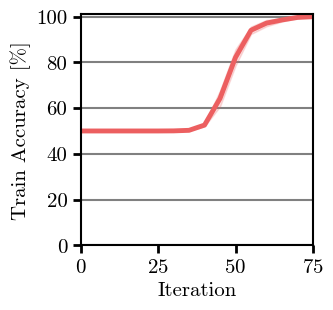

vanilla-gradient 0.005 1.0


/tmp/ipykernel_562380/2528739069.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


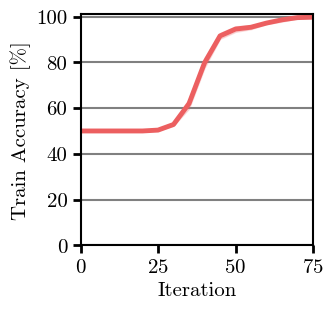

In [9]:
def plot_accuracies_over_epochs(accuracy_logs, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    datasplit = [m for m in accuracy_logs[0].keys() if m == "train"]

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    for s, split in enumerate(datasplit):
        plot_data = [accuracy_logs[i][split] for i in range(len(accuracy_logs))]
        plot_means = np.mean(plot_data, axis=0)
        plot_stds = np.std(plot_data, axis=0)

        xaxis = np.arange(0, len(plot_means)) * 5

        ax.plot(xaxis, plot_means, color=palette[s], label=split, linewidth=3.5, alpha=1)
        ax.fill_between(
            xaxis,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[s],
            alpha=0.2,
        )

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=xaxis[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel("Train Accuracy [%]")
    ax.set_xlabel("Iteration")
    ax.set_ylim([0.0, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim([0.0, xaxis[-1]])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 200])
    # ax.legend()
    plt.show()
    fig.savefig(fname)


toplot = maxacclrs["test"]
for name, lr, acc in toplot:
    print(name, lr, acc)
    plot_accuracies_over_epochs(
        [trainer.accuracy_log for trainer in trainers[lr][name]],
        fname=os.path.join(savepath, f"accuracy-lr-{lr}-{name}.svg"),
    )

### Plot Decision Boundaries

lfp-epsilon 0.00030000000000000003 1.0
(57460, 2)


/tmp/ipykernel_562380/3681178252.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap, 256)
/tmp/ipykernel_562380/3681178252.py:44: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


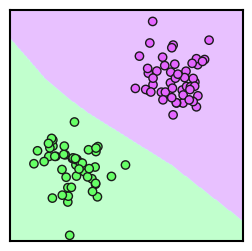

vanilla-gradient 0.005 1.0
(57460, 2)


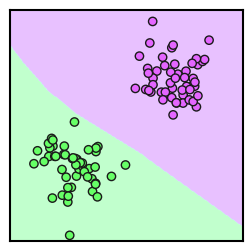

In [10]:
def plot_classifier_boundaries(
    models,
    dataset,
    xlim=(0.4, 2.61),
    ylim=(0.2, 2.8),
    colormap="gist_rainbow",
    fname="",
):
    xgrid = np.arange(xlim[0], xlim[1], 0.01)
    ygrid = np.arange(ylim[0], ylim[1], 0.01)

    xx, yy = np.meshgrid(xgrid, ygrid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))

    from matplotlib.colors import ListedColormap

    pastel = 0.4
    cmap = cm.get_cmap(colormap, 256)
    newcolors = [cmap(np.linspace(0.4, 0.92, 128))]
    newcolors = (1 - pastel) * np.repeat(newcolors, 2, axis=1)[0] + pastel * np.ones((256, 4))
    colormap = ListedColormap(newcolors.clip(max=1))

    edgecolor = np.ones(4) * 0.1

    # from matplotlib.colors import ListedColormap
    # colors = np.linspace(0, 1, 9)
    # palette = cm.get_cmap(colormap)(colors)
    # pastel = 0.0
    # palette = (1-pastel)*palette+pastel*np.ones((9, 4))
    # reduced_palette = np.array([palette[2], palette[8], palette[3]]) #green, grey, purple
    # colormap = ListedColormap(reduced_palette)

    yhats = []
    for model in models:
        yhat = (
            torch.nn.functional.softmax(model(torch.from_numpy(grid).float().to(device)), dim=1).detach().cpu().numpy()
        )
        # yhats.append(np.argmax(yhat, axis=1)/yhat.shape[1])
        yhats.append(yhat)

    yhat_mean = np.mean(yhats, axis=0)
    print(yhat_mean.shape)
    yhat_mean = np.argmax(yhat, axis=1)
    # yhat_std = np.std(yhats, axis=0)

    zz = yhat_mean.reshape(xx.shape)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    cnt = ax.contourf(xx, yy, zz, cmap=colormap, alpha=0.4)
    for c in cnt.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000001)

    samples = copy.deepcopy(dataset.samples)
    np.random.shuffle(samples)
    # samples = samples[:200]

    X = np.array([s[0] for s in samples])
    y = [s[1] for s in samples]
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=colormap, edgecolors=edgecolor, alpha=1, marker="o")

    ax.set_xticks([])
    ax.set_yticks([])
    # plt.axis("off")

    plt.show()

    fig.savefig(fname)


toplot = maxacclrs["test"]

if dataset_name == "blobs":
    xlim = (0.4, 2.61)
    ylim = (0.2, 2.8)
elif dataset_name == "circles":
    xlim = (-1.8, 1.61)
    ylim = (-1.61, 1.61)
elif dataset_name == "swirls":
    xlim = (-1.1, 1.1)
    ylim = (-1.1, 1.1)
for name, lr, acc in toplot:
    print(name, lr, acc)
    plot_classifier_boundaries(
        [trainer.model for trainer in trainers[lr][name]],
        test_dataset,
        xlim=xlim,
        ylim=ylim,
        fname=os.path.join(savepath, f"boundary-lr-{lr}-name-{name}.svg"),
    )

Init


/tmp/ipykernel_562380/2280722054.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)
/home/lweber/anaconda3/envs/lxtenv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


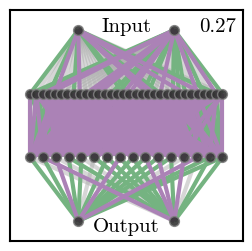

lfp-epsilon 0.00030000000000000003 1.0


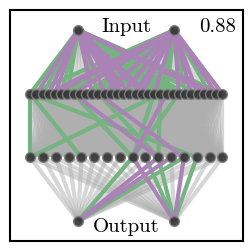

vanilla-gradient 0.005 1.0


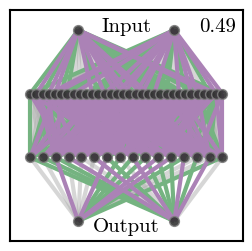

In [11]:
import networkx as nx


def visualize_weights(model, fname, colormap="PRGn"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    G = nx.Graph()
    layers = [
        module
        for module in model.modules()
        if not isinstance(module, torch.nn.Sequential)
        and not isinstance(module, ToyDataDense)
        and not isinstance(module, torch.nn.ReLU)
        and not isinstance(module, torch.nn.LeakyReLU)
    ]

    colors = np.linspace(0.15, 0.85, 3)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((3, 4))
    palette[1] *= (0.7, 0.7, 0.7, 0.5)

    nodes = []
    pos = {}
    edges = {"pos": [], "neg": [], "neutral": []}
    edge_colors = {"pos": [], "neg": [], "neutral": []}
    edge_alphas = {"pos": [], "neg": [], "neutral": []}
    for l, layer in enumerate(layers):
        # print([l for l in layer.named_parameters()])
        weights = layer.weight.data.detach().cpu().numpy()
        e_alphas = np.abs(weights)
        e_alphas /= np.max(e_alphas)
        # e_alphas *= 0.9
        # e_alphas += 0.1

        if l == 0:
            # Construct Input

            # print(weights)

            for i in range(weights.shape[1]):
                xcoords = np.linspace(-0.5, 0.5, weights.shape[1])
                nodename = f"I-{i}"
                nodes.append(nodename)
                pos[nodename] = (xcoords[i], len(layers) - 1)

        for i in range(weights.shape[0]):
            xcoords = (
                np.linspace(-1, 1, weights.shape[0])
                if l != len(layers) - 1
                else np.linspace(-0.5, 0.5, weights.shape[0])
            )
            nodename = f"L{l + 1}-{i}" if l != len(layers) - 1 else f"O-{i}"
            nodes.append(nodename)
            pos[nodename] = (xcoords[i], len(layers) - 1 - l - 1)

            for j in range(weights.shape[1]):
                pre = f"L{l}-{j}" if l > 0 else f"I-{j}"

                if weights[i][j] > 0 and e_alphas[i][j] > 0.25:
                    color = palette[2]
                    edges["pos"].append((pre, nodename))
                    edge_colors["pos"].append(color)
                    edge_alphas["pos"].append(e_alphas[i][j])
                elif weights[i][j] < 0 and e_alphas[i][j] > 0.25:
                    color = palette[0]
                    edges["neg"].append((pre, nodename))
                    edge_colors["neg"].append(color)
                    edge_alphas["neg"].append(e_alphas[i][j])
                else:
                    color = palette[1]
                    edges["neutral"].append((pre, nodename))
                    edge_colors["neutral"].append(color)
                    edge_alphas["neutral"].append(e_alphas[i][j])

    options = {"edgecolors": "tab:gray", "node_size": 50, "alpha": 0.9}
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=(0.2, 0.2, 0.2, 1.0), ax=ax, **options)
    collection_neutral = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges["neutral"],
        width=3,
        # alpha=1.0, #edge_alphas,
        edge_color=edge_colors["neutral"],
    )
    collection_neutral.set_zorder(0)

    collection_pos = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges["pos"],
        width=3,
        # alpha=1.0, #edge_alphas,
        edge_color=edge_colors["pos"],
    )
    collection_pos.set_zorder(1)

    collection_neg = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges["neg"],
        width=3,
        # alpha=1.0, #edge_alphas,
        edge_color=edge_colors["neg"],
    )

    color_grey_ratio = (len(edges["neutral"])) / (len(edges["pos"]) + len(edges["neg"]) + len(edges["neutral"]))

    collection_neg.set_zorder(1)
    ax.text(0, len(layers) - 1.1, "Input", ha="center", va="bottom")
    ax.text(0, -1.1, "Output", ha="center", va="center")
    ax.text(0.95, len(layers) - 1.1, f"{color_grey_ratio:.2f}", ha="center", va="bottom")
    # nx.draw_networkx_labels(G, pos, {n: n for n in nodes}, font_size=15, font_color="black")
    plt.show()
    fig.savefig(fname)


print("Init")

visualize_weights(init_models[0], fname=os.path.join(savepath, "weights-initmodel.svg"))
for name, lr, acc in toplot:
    print(name, lr, acc)
    visualize_weights(
        trainers[lr][name][0].model,
        fname=os.path.join(savepath, f"weights-name-{name}-lr-{lr}.svg"),
    )

Init


/tmp/ipykernel_562380/186962845.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


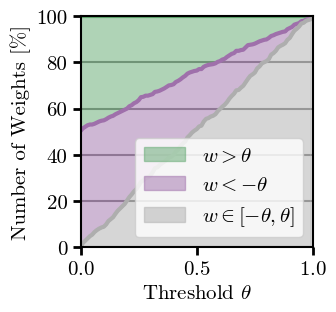

lfp-epsilon 0.00030000000000000003 1.0


/tmp/ipykernel_562380/186962845.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


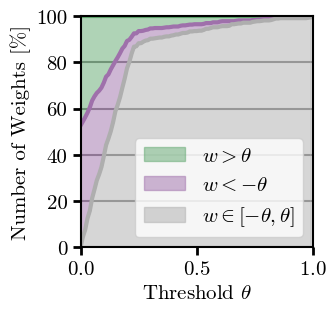

vanilla-gradient 0.005 1.0


/tmp/ipykernel_562380/186962845.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


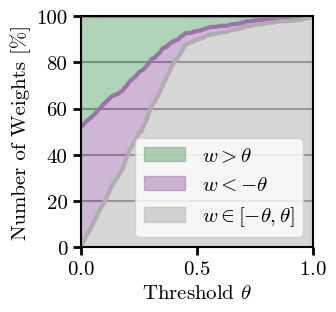

In [12]:
def visualize_threshold_ratios(model, fname, colormap="PRGn"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    layers = [
        module
        for module in model.modules()
        if not isinstance(module, torch.nn.Sequential)
        and not isinstance(module, ToyDataDense)
        and not isinstance(module, torch.nn.ReLU)
        and not isinstance(module, torch.nn.LeakyReLU)
    ]

    colors = np.linspace(0.15, 0.85, 3)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.2
    palette = (1 - pastel) * palette + pastel * np.ones((3, 4))
    palette[1] *= (0.7, 0.7, 0.7, 1.0)

    thresholds = np.arange(0, 1, 0.01)
    pos_ratios = []
    neg_ratios = []
    neutr_ratios = []
    for threshold in thresholds:
        n_pos = 0
        n_neg = 0
        n_neutr = 0
        for l, layer in enumerate(layers):
            weights = layer.weight.data.detach()
            normed_weights = weights / weights.abs().amax()

            n_pos += (normed_weights[normed_weights > 0].abs() > threshold).sum().cpu().numpy()
            n_neg += (normed_weights[normed_weights < 0].abs() > threshold).sum().cpu().numpy()
            n_neutr += (normed_weights.abs() <= threshold).sum().cpu().numpy()

        n_total = n_pos + n_neg + n_neutr
        pos_ratios.append(n_pos / n_total)
        neg_ratios.append(n_neg / n_total)
        neutr_ratios.append(n_neutr / n_total)

    pos_ratios = np.array(pos_ratios)
    neg_ratios = np.array(neg_ratios)
    neutr_ratios = np.array(neutr_ratios)

    ax.plot(
        thresholds,
        neutr_ratios + neg_ratios + pos_ratios,
        color=palette[2],
        linewidth=3,
    )
    ax.fill_between(
        thresholds,
        neutr_ratios + neg_ratios,
        neutr_ratios + neg_ratios + pos_ratios,
        color=palette[2],
        alpha=0.5,
        label=r"$w > \theta$",
    )
    ax.plot(thresholds, neutr_ratios + neg_ratios, color=palette[0], linewidth=3)
    ax.fill_between(
        thresholds,
        neutr_ratios,
        neutr_ratios + neg_ratios,
        color=palette[0],
        alpha=0.5,
        label=r"$w < -\theta$",
    )
    ax.plot(thresholds, neutr_ratios, color=palette[1], linewidth=3)
    ax.fill_between(
        thresholds,
        np.zeros_like(neutr_ratios),
        neutr_ratios,
        color=palette[1],
        alpha=0.5,
        label=r"$w \in [-\theta, \theta]$",
    )

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(linelocs, xmin=-1, xmax=400, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    ax.tick_params(length=6, width=2)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.set_xticks([0.0, 0.5, 1.0])

    ax.set_xlabel(r"Threshold $\theta$")
    ax.set_ylabel("Number of Weights [%]")

    ax.legend()

    plt.show()
    fig.savefig(fname)


print("Init")

visualize_threshold_ratios(init_models[0], fname=os.path.join(savepath, "weightratios-initmodel.svg"))
for name, lr, acc in toplot:
    print(name, lr, acc)
    visualize_threshold_ratios(
        trainers[lr][name][0].model,
        fname=os.path.join(savepath, f"weightratios-name-{name}-lr-{lr}.svg"),
    )